# Targeted vs. Untargeted PGD attacks

In this notebook we will experiment with **adversarial evasion attacks**, against a pre-trained model from robustbench. Exploring untargeted and targeted evasion attacks over multiple backends.

Evasion attacks (a.k.a. *adversarial examples*) consists of carefully perturbing
the input samples at *test time* to have them misclassified. An untargeted attack aims to make the classifiers misclassify the crafted input into any incorrect class, while a targeted attack forces it to predict a specific (wrong) class chosen by the attacker.

In [ ]:
%%capture --no-stdout
try:
    import secmlt
except ImportError:
   %pip install secml-torch[foolbox,adv_lib]

try:
  import robustbench
except ImportError:
   %pip install git+https://github.com/RobustBench/robustbench.git


#### Testing a Pre-trained Model on Clean Inputs
We will first load a pretrained classifier from robustbench, evaluating its performance in the standard scenario, *i.e. not under attack*.

In [2]:
%%capture
import torch
import torchvision.datasets
from robustbench.utils import load_model
from secmlt.metrics.classification import Accuracy, AttackSuccessRate
from secmlt.models.pytorch.base_pytorch_nn import BasePytorchClassifier
from torch.utils.data import DataLoader, Subset

In [3]:
%%capture
#Loading a pretrained model form robust bench
net = load_model(model_name="Rony2019Decoupling", dataset="cifar10", threat_model="L2")

#setting the device
device = "cuda" if torch.cuda.is_available() else "cpu"
net.to(device)

#loading the CIFAR10 Dataset
num_samples = 5
test_dataset = torchvision.datasets.CIFAR10(
    transform=torchvision.transforms.ToTensor(),
    train=False,
    root=".",
    download=True,
)
test_dataset = Subset(test_dataset, list(range(num_samples)))
test_data_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

cifar10_labels = {
    0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer",
    5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"
}

In [4]:
# Wrap model
model = BasePytorchClassifier(net)

# Test accuracy on original data
accuracy = Accuracy()(model, test_data_loader)
print("Testing the pretrained native model - Accuracy:", accuracy.item())

Testing the pretrained native model - Accuracy: 1.0


#### Instantiating Untargeted PGD Attack

Untargeted attacks refer to the case in which the attacker is satisfied with producing a generic misclassification (e.g., an airplane will be recognized as anything else but an airplane) and can be written as:

$$
\max_{\delta} L(x + \delta, y; \theta) \quad \text{s.t.} \quad \|\delta\|_p \leq \epsilon \quad \text{subject to} \quad l_b \preceq x + \delta \preceq l_u
$$

where  $L$ is the objective function of our attack (it defines the goal of the attacker, i.e., where to find adversarial examples), $x$ is the sample to perturb, $y$ is the true label, $\theta$ are the parameters of the model,  $\epsilon$ is the maximum allowed perturbation, $l_b$ and $l_u$ are the input-space bounds (for instance, images must be clipped in 0-1 or 0-255 to be valid samples) (Biggio et al., 2013).


Now, we are going to create multiple untargeted attacks against the previous loaded pre-trained model, using the **projected gradient descent (PGD)** algorithm proposed in Madry et al. (2018).


Which is implemented in SecML-Torch by the `PGD` class.

Let's define the attack parameters. First, we choose to generate an $l_∞$
perturbation within a maximum ball of radius `epsilon = 0.1` from the initial
point. The attack runs for `num_step = 10` iterations, with a `step_size = 0.02` per iteration. Since we are not targeting a specific class, we set `y_target = None` to perform an untargeted attack. Random initialization is disabled with `random_start = False`.

In [5]:
from secmlt.adv.backends import Backends
from secmlt.adv.evasion.perturbation_models import LpPerturbationModels
from secmlt.adv.evasion.pgd import PGD

In [6]:
# Create and run attack
epsilon = 0.1
num_steps = 5
step_size = 0.02
perturbation_model = LpPerturbationModels.LINF
y_target = None
pgd_untargeted = PGD(
    perturbation_model=perturbation_model,
    epsilon=epsilon,
    num_steps=num_steps,
    step_size=step_size,
    random_start=False,
    y_target=y_target,
    backend=Backends.NATIVE,
)
pgd_adv_ds_u = pgd_untargeted(model, test_data_loader)


#### Instantiating Targeted PGD Attack over Multiple Backends

Targeted attacks refer to the case in which the attacker wants to produce a specific misclassification (e.g, a ship must be recognized as a dog) and can be written as:

$$
\min_{\delta} L(x + \delta, y_t; \theta) \quad \text{s.t.} \quad \|\delta\|_p \leq \epsilon \quad \text{subject to} \quad l_b \preceq x + \delta \preceq l_u
$$

where we change the maximization to a minimization, since we want to minimize the error of the classifier w.r.t. the tarbet label $y_t$.

In this experiment with respect to the previous one, we are simply setting the target label `y_target = 5`,  corresponding to a dog.

In [7]:
# Create and run attack
epsilon = 0.1
num_steps = 10
step_size = 0.02
perturbation_model = LpPerturbationModels.LINF
y_target = 5
pgd_targeted = PGD(
    perturbation_model=perturbation_model,
    epsilon=epsilon,
    num_steps=num_steps,
    step_size=step_size,
    random_start=False,
    y_target=y_target,
    backend=Backends.NATIVE,
)
pgd_adv_ds_t = pgd_targeted(model, test_data_loader)


In [8]:
n_robust_accuracy = AttackSuccessRate(y_target=y_target)(model, pgd_adv_ds_t)
print("ASR (PGD): ", n_robust_accuracy.item())

ASR (PGD):  1.0


#### Visualizing Adversarial Perturbation

We now visualize the adversarial perturbations applied by each backend on the third sample from the test set, in the target attack scenario.
This comparison helps illustrate both the effectiveness and visual effect of the attacks.


UNTARGETED examples
Original predictions: ['cat', 'ship', 'ship', 'airplane', 'frog']
Adversarial predictions: ['dog', 'automobile', 'automobile', 'ship', 'deer']


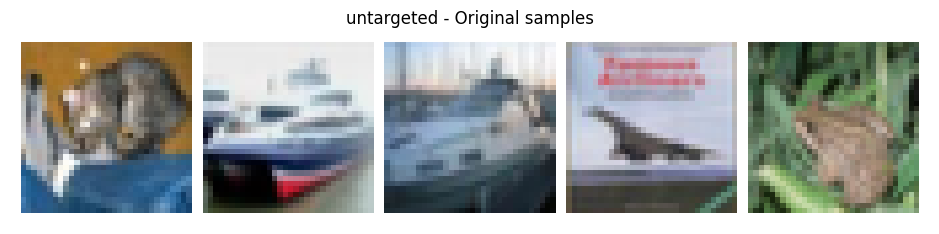

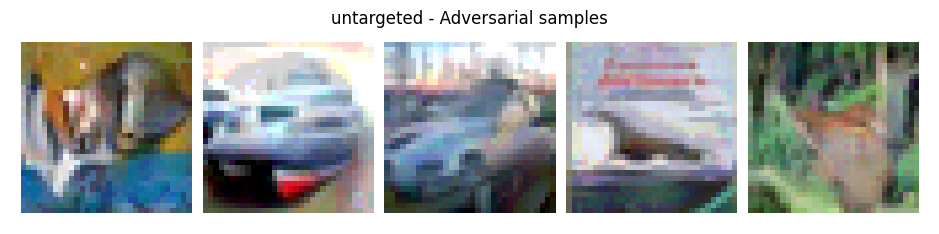


TARGETED examples
Original predictions: ['cat', 'ship', 'ship', 'airplane', 'frog']
Adversarial predictions: ['dog', 'dog', 'dog', 'dog', 'dog']


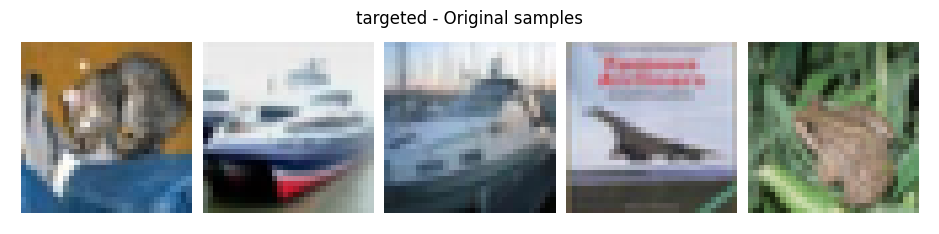

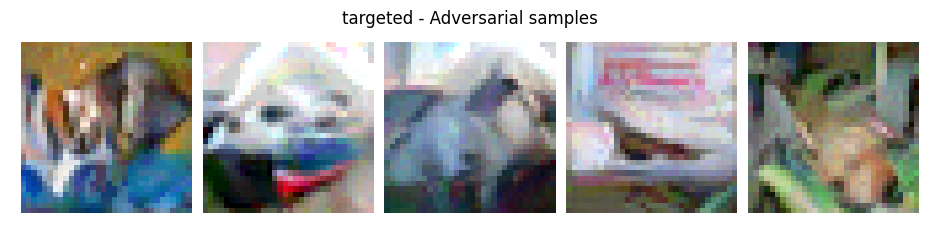

In [9]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

perturbed_datasets = {
    "untargeted": pgd_adv_ds_u,
    "targeted": pgd_adv_ds_t,
}

xs_orig, ys_true = next(iter(test_data_loader))

@torch.no_grad()
def get_predictions(x):
    return model(x).argmax(1)

def show_grid(tensors, nrow=5, title=None):
    grid = make_grid(tensors, nrow=nrow, normalize=True, pad_value=1.0)
    plt.figure(figsize=(nrow * 2.5, 2.5))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

# collect & show
for name, adv_ds in perturbed_datasets.items():
    xs_adv, ys_adv = next(iter(adv_ds))
    preds_orig = get_predictions(xs_orig)
    preds_adv = get_predictions(xs_adv)

    print(f"\n{name.upper()} examples")
    print("Original predictions:", [cifar10_labels[p.item()] for p in preds_orig[:5]])
    print("Adversarial predictions:", [cifar10_labels[p.item()] for p in preds_adv[:5]])

    # show original and adversarial samples
    show_grid(xs_orig[:5], title=f"{name} - Original samples")
    show_grid(xs_adv[:5], title=f"{name} - Adversarial samples")


### Tracking the objective

It is useful to check what the attack is doing under the API that exposes the attack. We can check the value of the loss function and of the predictions from the model through the use of the trackers (supported by SecML).

In [10]:
# Import tracking components
from secmlt.trackers import (
    LossTracker,
    ScoresTracker,
)

# Set up individual trackers
trackers = [
    LossTracker(),
    ScoresTracker(),
]

pgd_attack = PGD(
    perturbation_model=perturbation_model,
    epsilon=epsilon,
    num_steps=num_steps,
    step_size=step_size,
    random_start=False,
    backend=Backends.NATIVE,
    trackers=trackers,
)

pgd_adv_ds = pgd_attack(model, test_data_loader)


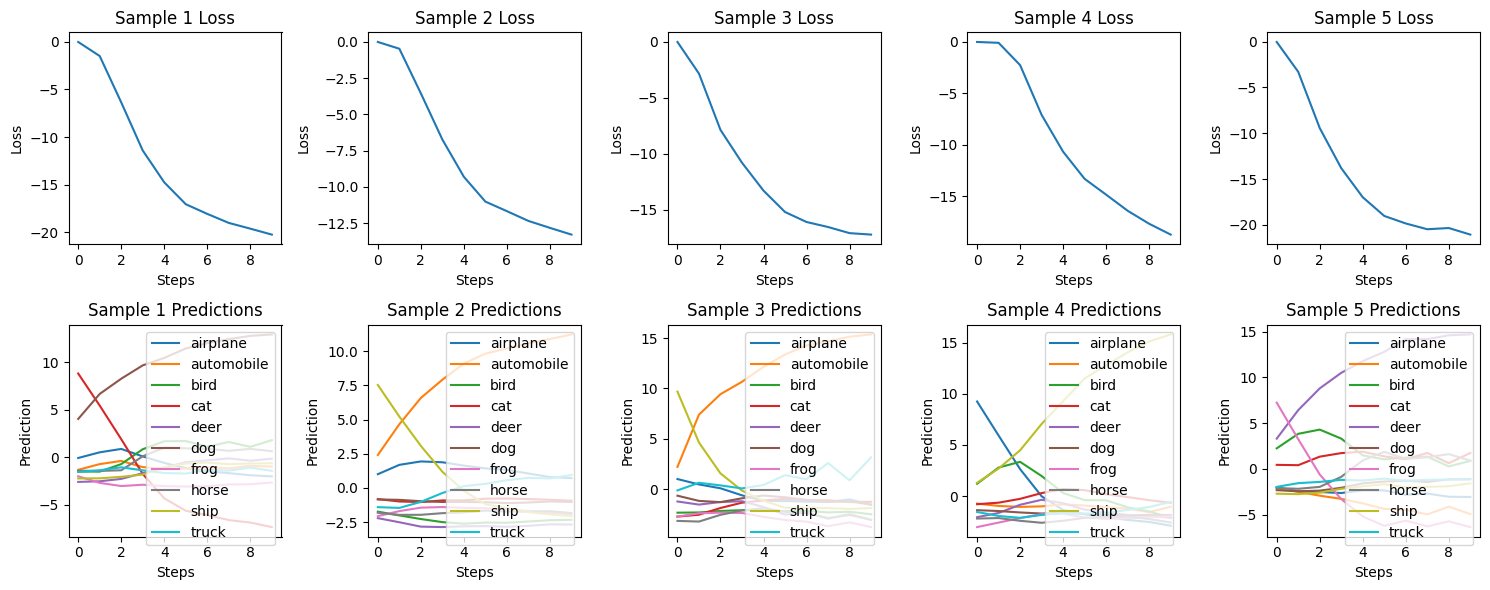

In [11]:
# Inspect tracker histories
loss_hist = trackers[0].get()   # LossTracker: shape [N_samples, T_iters]
scores_hist = trackers[1].get()  # PredictionTracker: shape [N_samples, T_iters]

# get number of samples and steps
n_samples, n_classes, n_steps = scores_hist.shape

fig, axes = plt.subplots(2, n_samples, figsize=(3 * n_samples, 6))

# Plot loss history
for i in range(n_samples):
    axes[0, i].plot(range(n_steps), loss_hist[i, :].cpu().numpy())
    axes[0, i].set_title(f"Sample {i+1} Loss")
    axes[0, i].set_xlabel("Steps")
    axes[0, i].set_ylabel("Loss")
    for c in range(n_classes):
        axes[1, i].plot(range(n_steps), scores_hist[i, c,:].cpu().numpy(), label=cifar10_labels[c])
        axes[1, i].set_title(f"Sample {i+1} Predictions")
        axes[1, i].set_xlabel("Steps")
        axes[1, i].set_ylabel("Prediction")

    # make a third row where there is the legend for the classes
    axes[1, i].legend()



plt.tight_layout()
plt.show()

For other tutorials, go to https://secml-torch.readthedocs.io

# References:

* Battista Biggio, Igino Corona, Davide Maiorca, Blaine Nelson, Nedim Šrndić, Pavel Laskov, Giorgio Giacinto, and Fabio Roli. Evasion attacks against machine learning at test time. In Joint European conference on machine learning and knowledge discovery in databases, 387–402. Springer, 2013.
* Aleksander Madry, Aleksandar Makelov, Ludwig Schmidt, Dimitris Tsipras, and Adrian Vladu. Towards deep learning models resistant to adversarial attacks. In International Conference on Learning Representations. 2018. URL: https://openreview.net/forum?id=rJzIBfZAb.